# 从零实现

In [17]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [18]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

labels.shape, features[0]

(torch.Size([1000]), tensor([ 1.7324, -0.0527]))

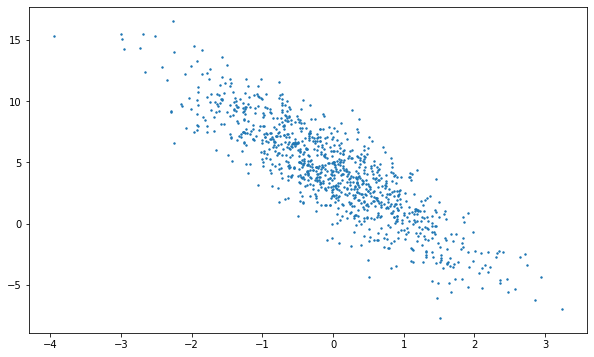

In [19]:
plt.figure(figsize=(10,6))
# plt.scatter(features[:,0], labels, 1)  # first param
plt.scatter(features[:,1], labels, 2)  # secend param

In [20]:
batch_size = 10

# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)


In [21]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data


In [22]:
# 训练模型
lr = 0.03
num_epochs = 4
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


epoch 1, loss 0.036085
epoch 2, loss 0.000126
epoch 3, loss 0.000049
epoch 4, loss 0.000049


In [23]:
print(true_w, '\n', w)
print(true_b, '\n', b)


[2, -3.4] 
 tensor([[ 1.9998],
        [-3.3999]], requires_grad=True)
4.2 
 tensor([4.1995], requires_grad=True)


# 简洁实现

In [24]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)


In [25]:
# 读取数据
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)


In [28]:
import torch.nn as nn


class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [29]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

print(net)
print(net[0])

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [30]:
# # 写法二
# net = nn.Sequential()
# net.add_module('linear', nn.Linear(num_inputs, 1))
# # net.add_module ......

# # 写法三
# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([
#           ('linear', nn.Linear(num_inputs, 1))
#           # ......
#         ]))

In [31]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.2255, 0.0689]], requires_grad=True)
Parameter containing:
tensor([-0.3384], requires_grad=True)


In [32]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)


Parameter containing:
tensor([0.], requires_grad=True)

In [33]:
loss = nn.MSELoss()

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [35]:
# optimizer =optim.SGD([
#                 # 如果对某个参数不指定学习率，就使用最外层的默认学习率
#                 {'params': net.subnet1.parameters()}, # lr=0.03
#                 {'params': net.subnet2.parameters(), 'lr': 0.01}
#             ], lr=0.03)


In [36]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍


In [37]:
# 训练模型
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))


epoch 1, loss: 12.236777
epoch 2, loss: 1.761754
epoch 3, loss: 1.276958


In [38]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.7062, -2.8447]], requires_grad=True)
4.2 Parameter containing:
tensor([3.4955], requires_grad=True)
